In [4]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from afqinsight.nn.utils import prep_fa_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug




In [5]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [6]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [7]:
class Conv1DEncoder_one_tract(nn.Module):
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2)  
        self.conv2 = nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=2)  
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv1d(64, latent_dims, kernel_size=5, stride=2, padding=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)

        self.relu = nn.ReLU()


    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = F.relu(self.conv1(x)) 
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)   
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.conv4(x)
        return x
    
class Conv1DDecoder_one_tract(nn.Module):
    def __init__(self, latent_dims=20):
        super().__init__()

        self.deconv1 = nn.ConvTranspose1d(latent_dims, 64, kernel_size=5, stride=2, padding=2, output_padding=0)  
        self.deconv2 = nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=0)  
        self.deconv3 = nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=2, output_padding=2)
        self.deconv4 = nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1)

        self.relu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.deconv1(x)) 
        x = F.relu(self.deconv2(x))   
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        x = self.sigmoid(x)
        return x
        # return x.view(batch_size, -1)

class Conv1DAutoencoder_one_tract(nn.Module): 
    def __init__(self, latent_dims=20, dropout=0.2):
        super().__init__()
        self.encoder = Conv1DEncoder_one_tract(latent_dims, dropout=dropout)
        self.decoder = Conv1DDecoder_one_tract(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        x_prime = self.decoder(z)
        return x_prime

In [8]:
def reconstruction_loss(x, x_hat, kl_div=0.0, reduction="mean"):
    """
    Compute the reconstruction loss (MSE) and optionally add a KL term.
    
    Parameters
    ----------
    x : torch.Tensor
        Original input tensor.
    x_hat : torch.Tensor
        Reconstructed output from the autoencoder.
    kl_div : float
        KL divergence term (VAE only). Defaults to 0 for a standard autoencoder.
    reduction : str
        Reduction mode: "sum" or "mean". Defaults to "sum".
    
    Returns
    -------
    torch.Tensor
        Scalar loss value.
    """
    # e.g. use MSE loss
    recon_loss = F.mse_loss(x_hat, x, reduction="mean")
    total_loss = recon_loss + kl_div
    return total_loss

In [9]:
def train_multiple_latent_dimensions(train_data, val_data, epochs=100, lr=0.001, sigma=0.03):
    latent_dims = list(range(10, 101, 10))  # [10, 20, ..., 100]
    results = []

    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim}")

        # Initialize a new autoencoder for each latent dimension
        model = Conv1DAutoencoder_one_tract(latent_dims=latent_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)

        train_rmse_per_epoch = []
        val_rmse_per_epoch = []
        best_val_loss = float('inf')  # Track the best (lowest) validation RMSE
        best_model_state = None     # Save the best model state

        for epoch in range(epochs):
            # Training
            model.train()
            running_loss = 0
            running_rmse = 0
            items = 0

            for x, _ in train_data:  # x shape: (batch_size, 48, 100)
                batch_size = x.size(0)
                tract_data = x[:, 0:1, :].to(device)  # Shape: (batch_size, 100)

                opt.zero_grad()
                x_hat = model(tract_data)

                loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
                batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                loss.backward()
                opt.step()

                items += tract_data.size(0)
                running_loss += loss.item()
                running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

            scheduler.step(running_loss / items)
            avg_train_rmse = running_rmse / items
            train_rmse_per_epoch.append(avg_train_rmse)

            # Validation
            model.eval()
            val_rmse = 0
            val_items = 0

            with torch.no_grad():
                for x, _ in val_data:
                    tract_data = x[:, 0:1, :].to(device)
                    x_hat = model(tract_data)
                    batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
                    val_items += tract_data.size(0)
                    val_rmse += batch_val_rmse.item() * tract_data.size(0)

            avg_val_rmse = val_rmse / val_items
            val_rmse_per_epoch.append(avg_val_rmse)

            # Check and save the best model state if current validation loss is lower
            if avg_val_rmse < best_val_loss:
                best_val_loss = avg_val_rmse
                best_model_state = model.state_dict()

            print(f"Latent Dim {latent_dim} - Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}")

        results.append({
            "latent_dim": latent_dim,
            "train_rmse_per_epoch": train_rmse_per_epoch,
            "val_rmse_per_epoch": val_rmse_per_epoch,
            "best_val_loss": best_val_loss,
            "best_model_state": best_model_state  # Optional: Save checkpoint for later use
        })

    return results

In [10]:
results = train_multiple_latent_dimensions(train_loader, val_loader)

Training Autoencoder with Latent Dimension: 10
Latent Dim 10 - Epoch 1, Train RMSE: 0.0811, Val RMSE: 0.0800
Latent Dim 10 - Epoch 2, Train RMSE: 0.0683, Val RMSE: 0.0590
Latent Dim 10 - Epoch 3, Train RMSE: 0.0558, Val RMSE: 0.0542
Latent Dim 10 - Epoch 4, Train RMSE: 0.0526, Val RMSE: 0.0504
Latent Dim 10 - Epoch 5, Train RMSE: 0.0484, Val RMSE: 0.0417
Latent Dim 10 - Epoch 6, Train RMSE: 0.0424, Val RMSE: 0.0325
Latent Dim 10 - Epoch 7, Train RMSE: 0.0335, Val RMSE: 0.0265
Latent Dim 10 - Epoch 8, Train RMSE: 0.0291, Val RMSE: 0.0225
Latent Dim 10 - Epoch 9, Train RMSE: 0.0268, Val RMSE: 0.0207
Latent Dim 10 - Epoch 10, Train RMSE: 0.0253, Val RMSE: 0.0196
Latent Dim 10 - Epoch 11, Train RMSE: 0.0243, Val RMSE: 0.0214
Latent Dim 10 - Epoch 12, Train RMSE: 0.0234, Val RMSE: 0.0187
Latent Dim 10 - Epoch 13, Train RMSE: 0.0229, Val RMSE: 0.0182
Latent Dim 10 - Epoch 14, Train RMSE: 0.0219, Val RMSE: 0.0193
Latent Dim 10 - Epoch 15, Train RMSE: 0.0213, Val RMSE: 0.0178
Latent Dim 10 - E

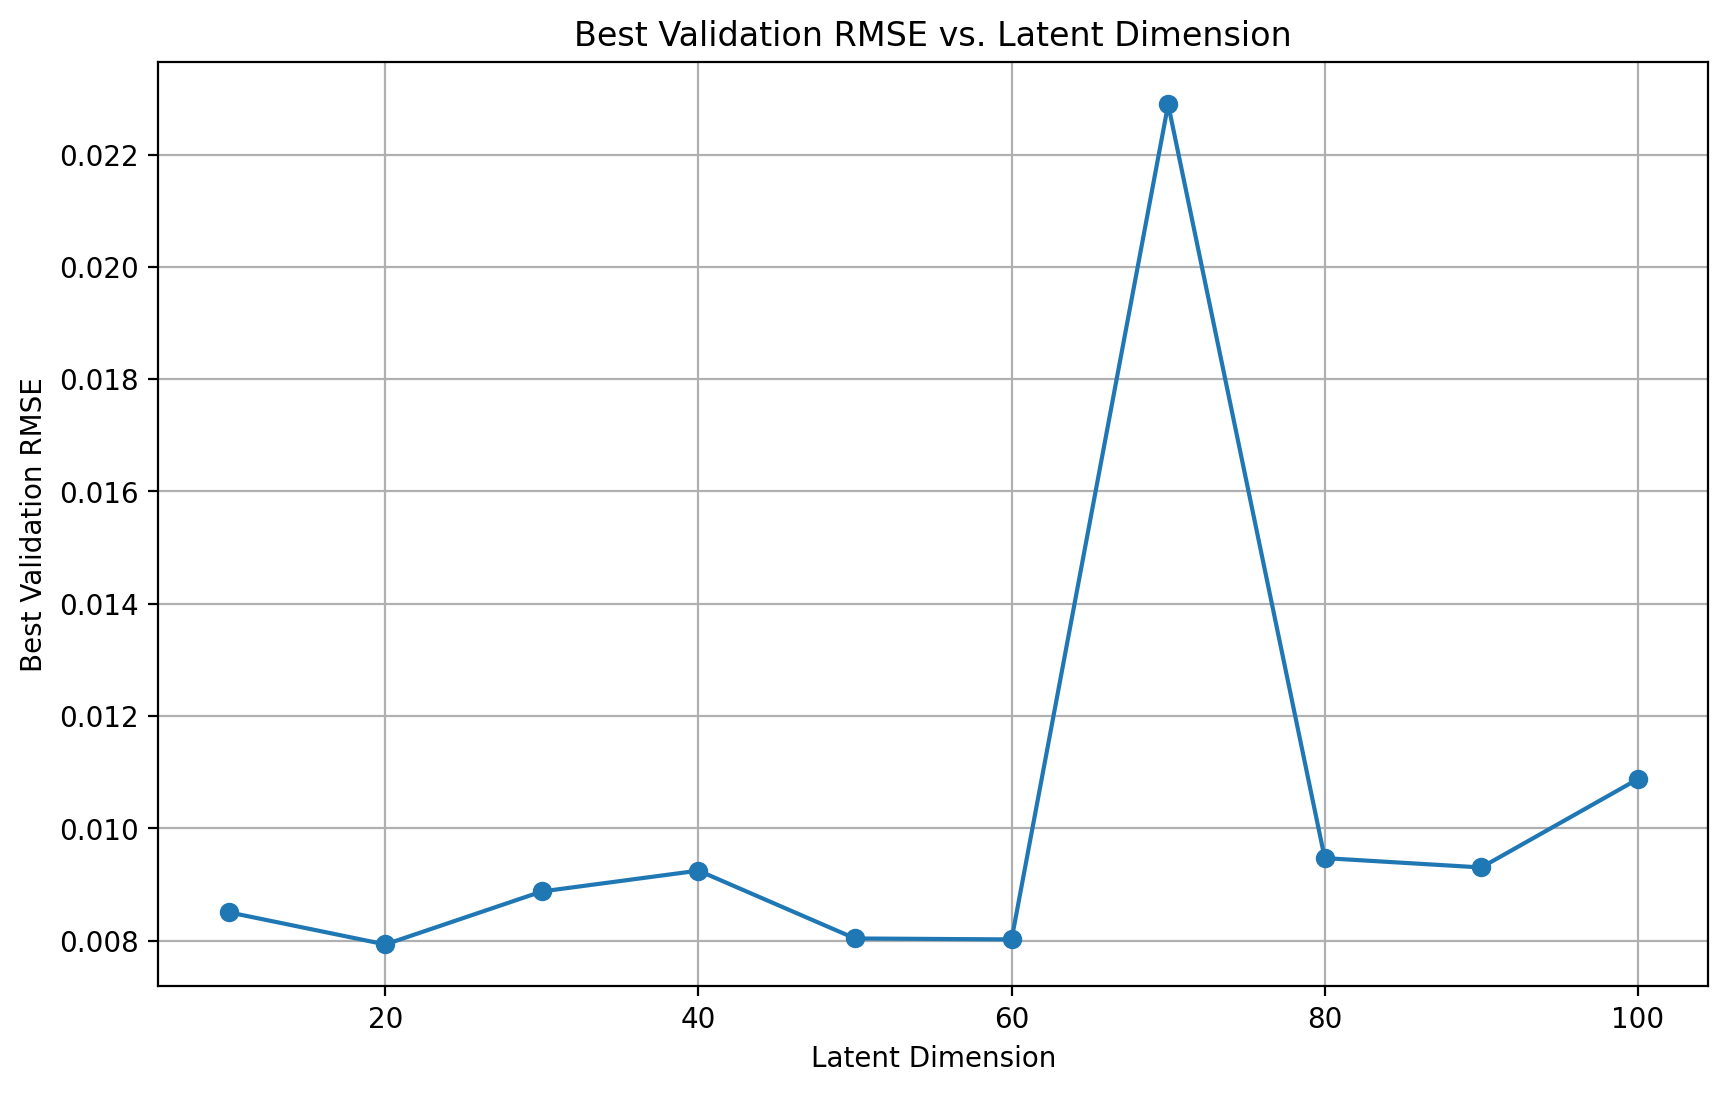

In [11]:
import matplotlib.pyplot as plt

latent_dims = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

latent_dims = [result["latent_dim"] for result in results]
best_val_losses = [result["best_val_loss"] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Latent Dimension")
plt.grid()
plt.show()

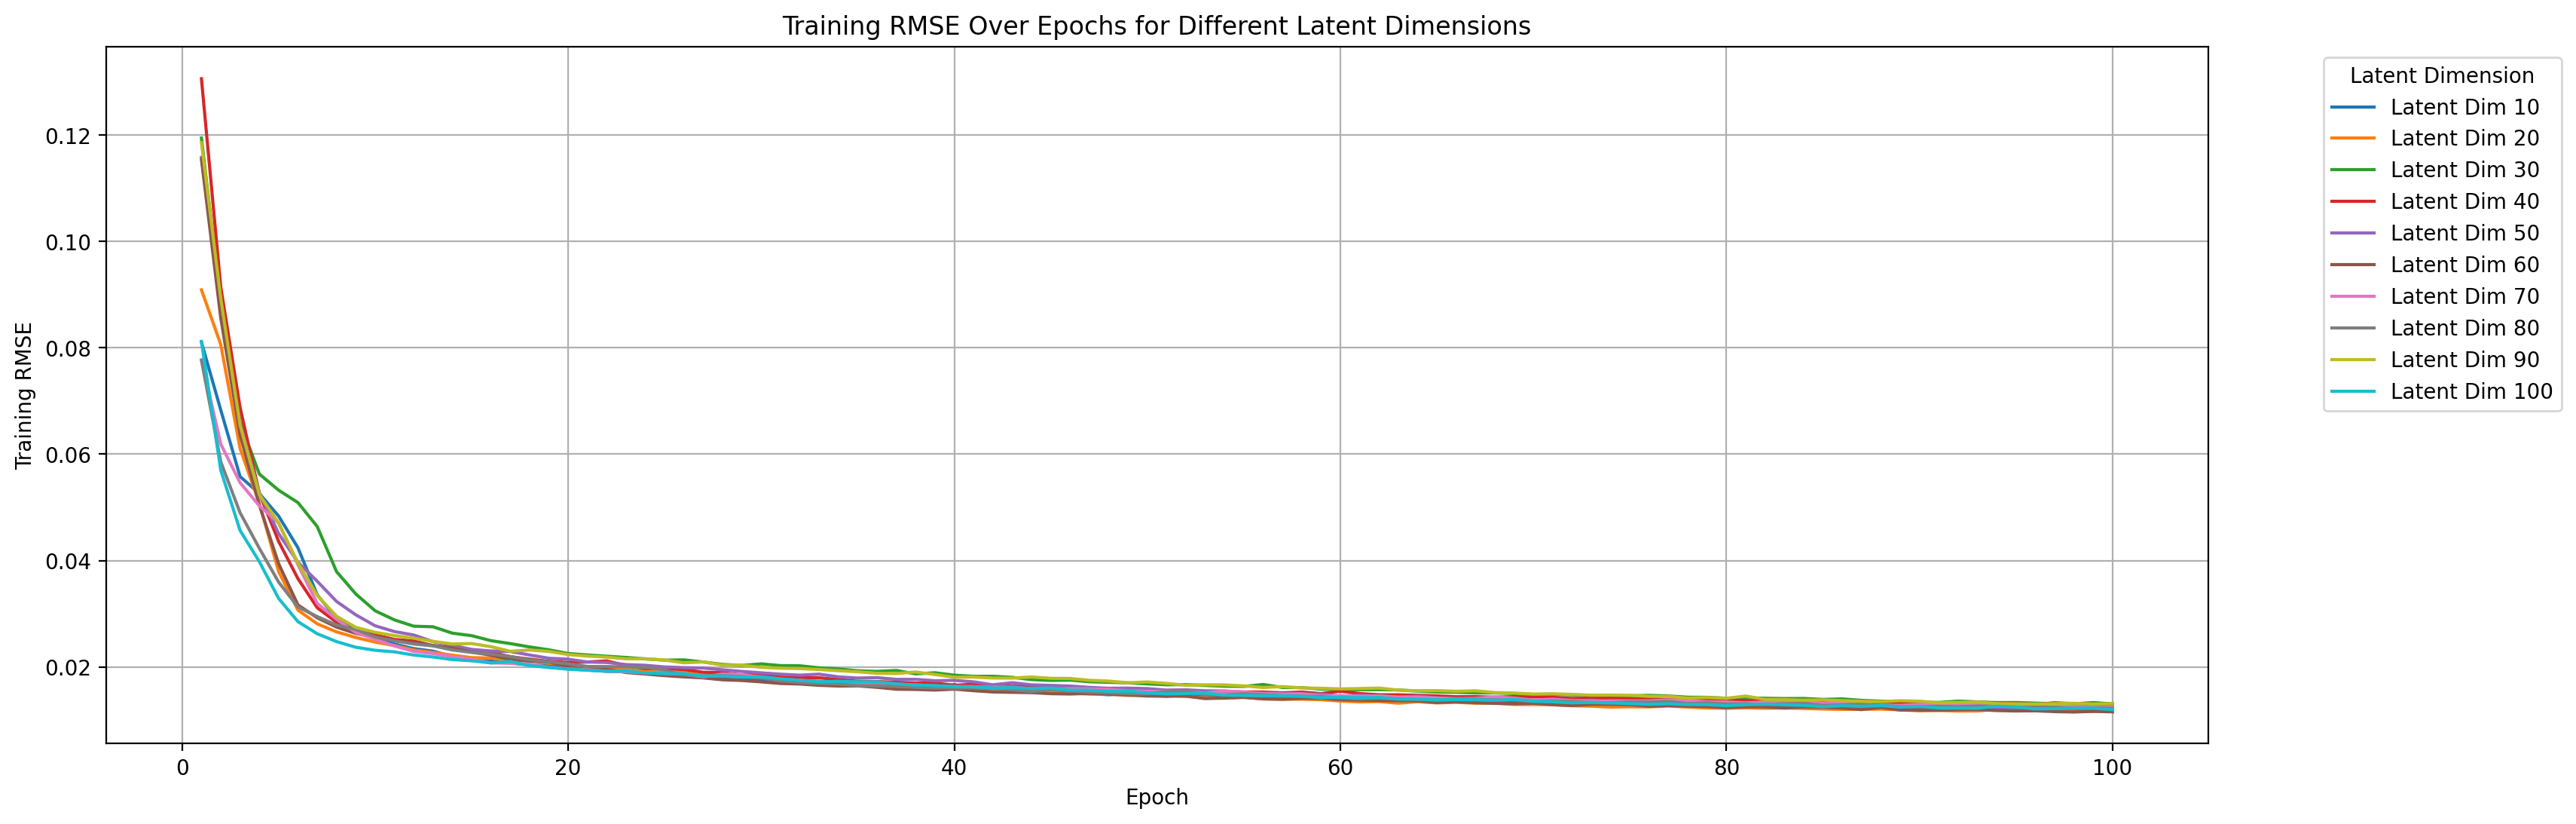

In [12]:
#plot 1, train rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results: 
    plt.plot(
        range(1, len(result["train_rmse_per_epoch"]) + 1),
        result["train_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}",  
    )
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.title("Training RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()

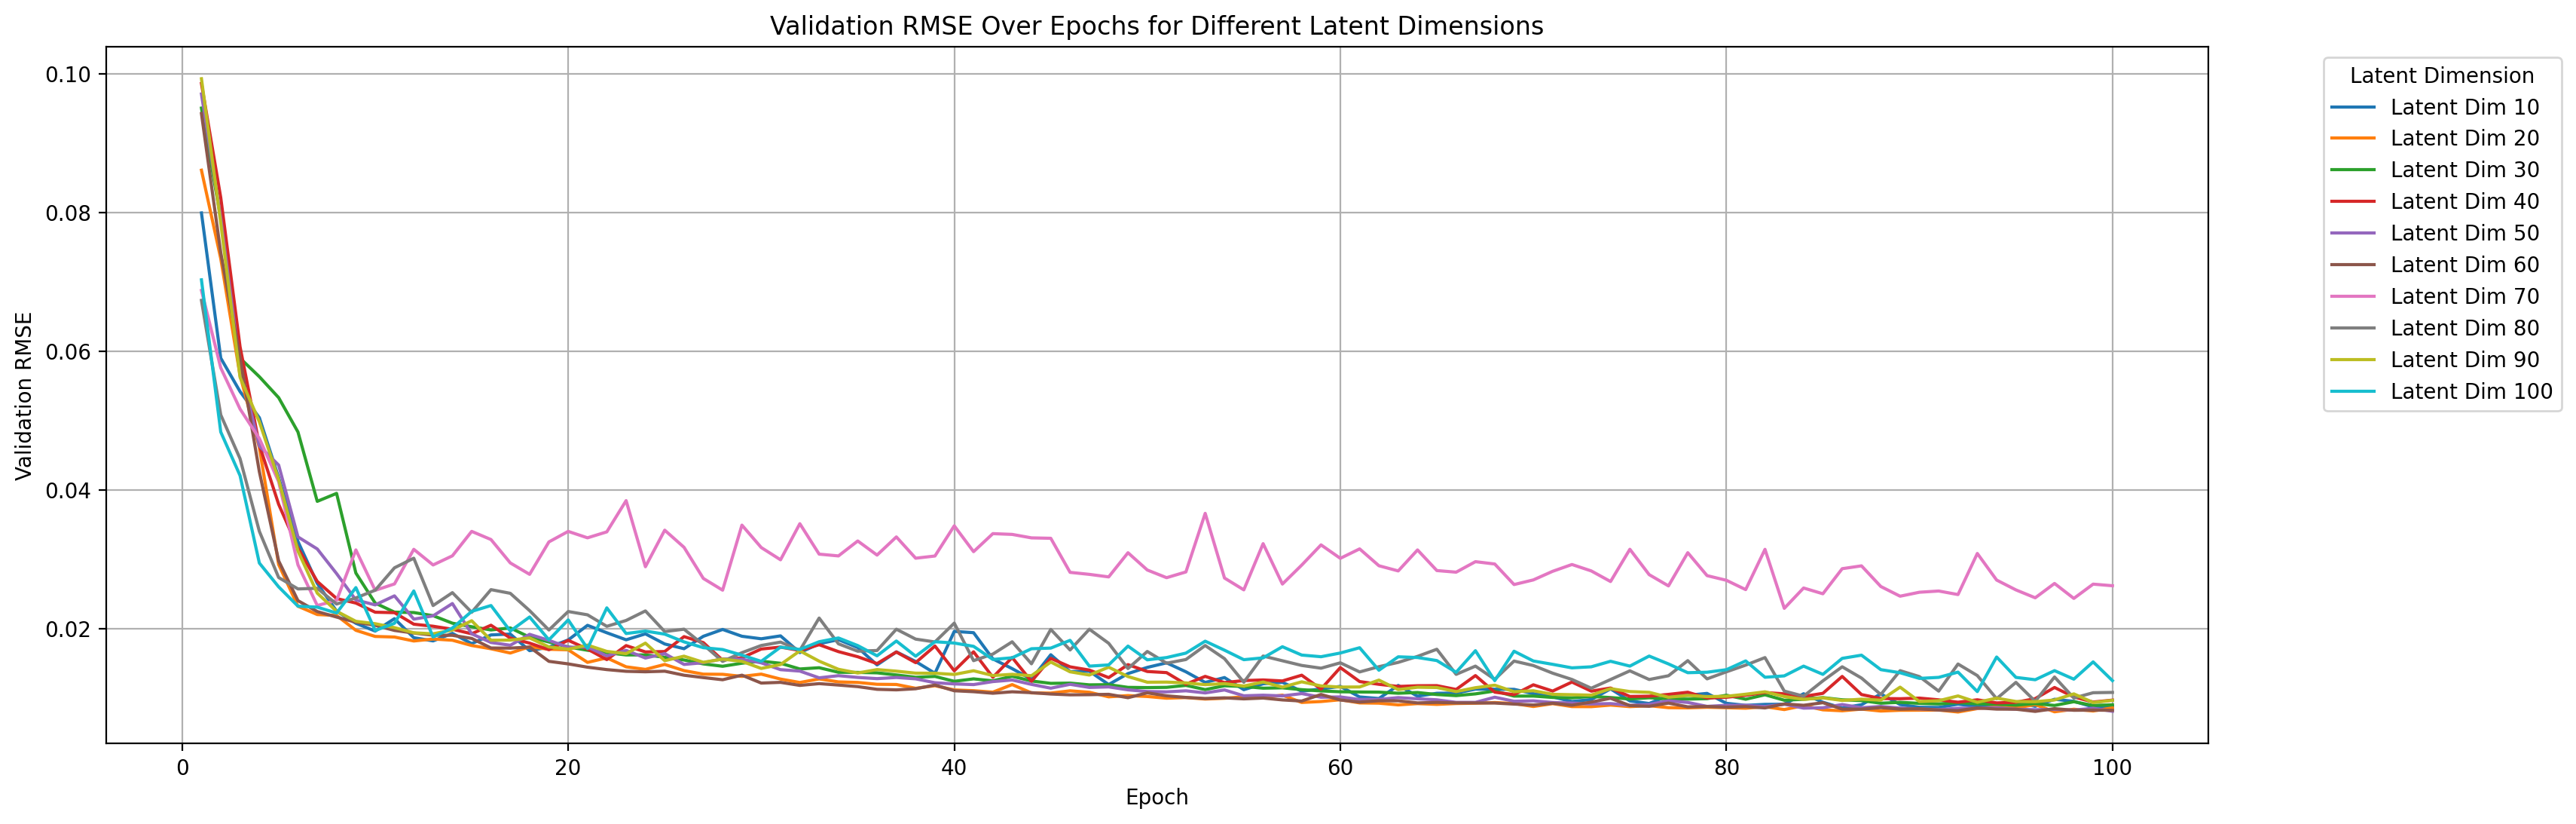

In [13]:
#plot 2, val rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results:  
    plt.plot(
        range(1, len(result["val_rmse_per_epoch"]) + 1),
        result["val_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}", 
    )
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()